In [1]:
# Import dependencies
import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display

import pathlib
import PIL
import PIL.Image
import cv2
import os

from tqdm import tqdm

from tools.utils import *
from tools.datasets import *
from tools.models import *

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU :D')
else:
    device = torch.device('cpu')
    print('Using CPU D:')

dataset_dir = '../data/mini_speech_commands'
mini_speech_commands = MiniSpeechCommandsDataset(dataset_dir)
waveform, sample_rate, label = mini_speech_commands[0]
print(f"Forma do waveform: {waveform.shape}, Taxa de amostragem: {sample_rate}, Rótulo: {label}")

Using GPU :D
Forma do waveform: torch.Size([1, 16000]), Taxa de amostragem: 16000, Rótulo: 0


In [2]:
max_frames = 101  # Example
features, labels = prepare_features(mini_speech_commands, max_frames)
print(features.shape, labels.shape)

(8000, 1, 201, 101) (8000,)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [4]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

## Creating Model

You can find model in ``tools/model.py``. It is a simple CNN with residual blocks. Also you can find the code for training and testing in ``tools/basemode.py``, where I have used the my personal implementation of the model with easy functions to compile e .fit() the model. So, you can easy import CNN and train it, in my library you can use validation_split on fit() function, so you can use it to train and validate the model. 

You can see the model architecture below:

```python
class ResnetCNN(BaseModel):
    def __init__(self,
                 in_channels=1,
                 num_filters=16,
                 num_filters_list=[],
                 output_dim=1,
                 kernel_size=3,
                 kernel_sizes=[],
                 num_conv_layers=3,
                 dropout=0.5):
        super(ResnetCNN, self).__init__()
        if not num_filters_list:
            num_filters_list = [num_filters] * num_conv_layers
            
        if not kernel_sizes:
            kernel_sizes = [kernel_size] * num_conv_layers

        if len(num_filters_list) != num_conv_layers:
            num_conv_layers = len(num_filters_list)
        layers = []
        for idx in range(num_conv_layers):
            conv_layer = ResidualBlock(in_channels=in_channels,
                                out_channels=num_filters_list[idx],
                                kernel_size=kernel_sizes[idx])
            layers.append(conv_layer)
            layers.append(nn.BatchNorm2d(num_filters_list[idx]))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = num_filters_list[idx]
        
        self.conv_layers = nn.Sequential(*layers)
        self.pool = nn.AdaptiveMaxPool2d(output_size=1)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(num_filters_list[-1], num_filters_list[-1]) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(num_filters_list[-1], output_dim)
        
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pool(x)
        x = x.squeeze(-1)
        x = x.squeeze(-1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
```

In [5]:
in_channels = 1
num_filters_list = [16, 32, 64, 64, 64]
kernel_sizes = [3, 3, 3, 3, 3]
output_dim = 8
model = ResnetCNN(in_channels=in_channels,
                  num_filters_list=num_filters_list,
                  kernel_sizes=kernel_sizes,
                  output_dim=output_dim) 

model.compile(optimizer=torch.optim.Adam(model.parameters(), lr=4e-3),
                loss_fn=nn.CrossEntropyLoss(),
                device='cuda',
                metrics=["accuracy"])

history = model.fit(train_dataset, 
                    n_epochs=15, 
                    validation_split=0.2)

Using device: cuda
Dataset dividido em 5120 amostras para treinamento e 1280 para validação.
Epoch 1/15


100%|██████████| 80/80 [00:06<00:00, 12.07it/s, batch_loss=1.92]


loss: 2.0718 - val_loss: 1.9306 - accuracy: 0.2719


Epoch 2/15


100%|██████████| 80/80 [00:03<00:00, 20.08it/s, batch_loss=1.38]


loss: 1.6224 - val_loss: 1.6704 - accuracy: 0.3797


Epoch 3/15


100%|██████████| 80/80 [00:03<00:00, 20.90it/s, batch_loss=0.944]


loss: 0.9903 - val_loss: 0.9680 - accuracy: 0.6047


Epoch 4/15


100%|██████████| 80/80 [00:03<00:00, 21.43it/s, batch_loss=0.587]


loss: 0.6205 - val_loss: 0.5253 - accuracy: 0.8055


Epoch 5/15


100%|██████████| 80/80 [00:03<00:00, 21.42it/s, batch_loss=0.777]


loss: 0.4631 - val_loss: 0.3550 - accuracy: 0.8812


Epoch 6/15


100%|██████████| 80/80 [00:03<00:00, 21.45it/s, batch_loss=0.405]


loss: 0.3540 - val_loss: 0.2755 - accuracy: 0.9125


Epoch 7/15


100%|██████████| 80/80 [00:03<00:00, 21.42it/s, batch_loss=0.318]


loss: 0.2928 - val_loss: 0.4619 - accuracy: 0.8703


Epoch 8/15


100%|██████████| 80/80 [00:03<00:00, 21.43it/s, batch_loss=0.197] 


loss: 0.2589 - val_loss: 0.2662 - accuracy: 0.9187


Epoch 9/15


100%|██████████| 80/80 [00:03<00:00, 21.36it/s, batch_loss=0.081] 


loss: 0.2081 - val_loss: 0.2600 - accuracy: 0.9156


Epoch 10/15


100%|██████████| 80/80 [00:03<00:00, 21.37it/s, batch_loss=0.469] 


loss: 0.2096 - val_loss: 0.2107 - accuracy: 0.9383


Epoch 11/15


100%|██████████| 80/80 [00:03<00:00, 21.38it/s, batch_loss=0.113] 


loss: 0.1667 - val_loss: 0.3221 - accuracy: 0.9031


Epoch 12/15


100%|██████████| 80/80 [00:03<00:00, 21.33it/s, batch_loss=0.0315]


loss: 0.1427 - val_loss: 0.2859 - accuracy: 0.9125


Epoch 13/15


100%|██████████| 80/80 [00:03<00:00, 21.32it/s, batch_loss=0.176] 


loss: 0.1410 - val_loss: 0.2344 - accuracy: 0.9211


Epoch 14/15


100%|██████████| 80/80 [00:03<00:00, 21.29it/s, batch_loss=0.148] 


loss: 0.1442 - val_loss: 0.1954 - accuracy: 0.9391


Epoch 15/15


100%|██████████| 80/80 [00:03<00:00, 21.28it/s, batch_loss=0.0675]


loss: 0.1232 - val_loss: 0.2252 - accuracy: 0.9305




In [58]:
history_custom = model.history
history_custom['metrics'] = {'accuracy': history_custom['metrics']['accuracy']}

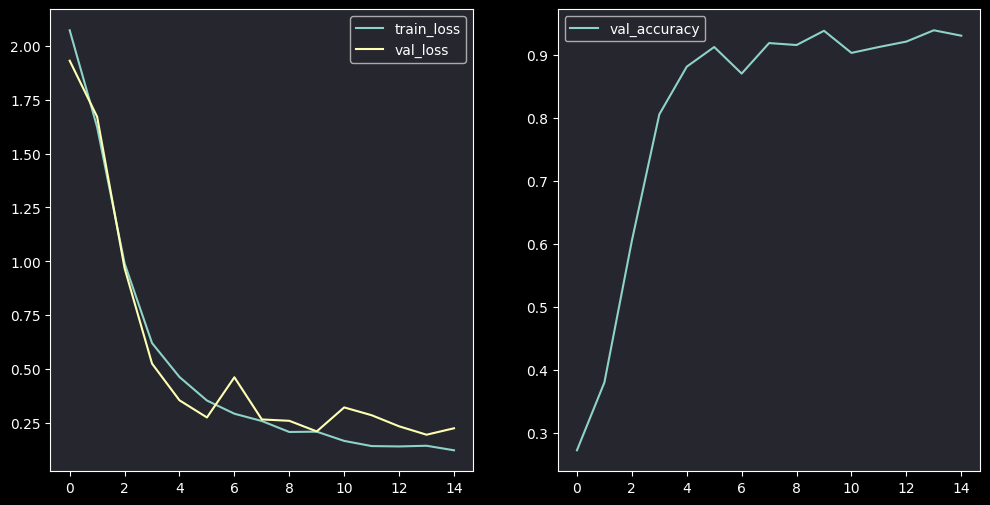

In [62]:
model.plot_history(history=history_custom, 
                   dark_mode=True)

In [48]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
# Confusion matrix
model.eval()
all_preds = []
all_labels = []
metric_values = {}
device = 'cpu'
with torch.no_grad():
    for batch in test_loader:
        X_, y_ = batch
        # print(X_.shape)
        # print(y_.shape, y_)
        X_ = X_.to(device)
        y_ = y_.to(device)
        outputs = model(X_)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

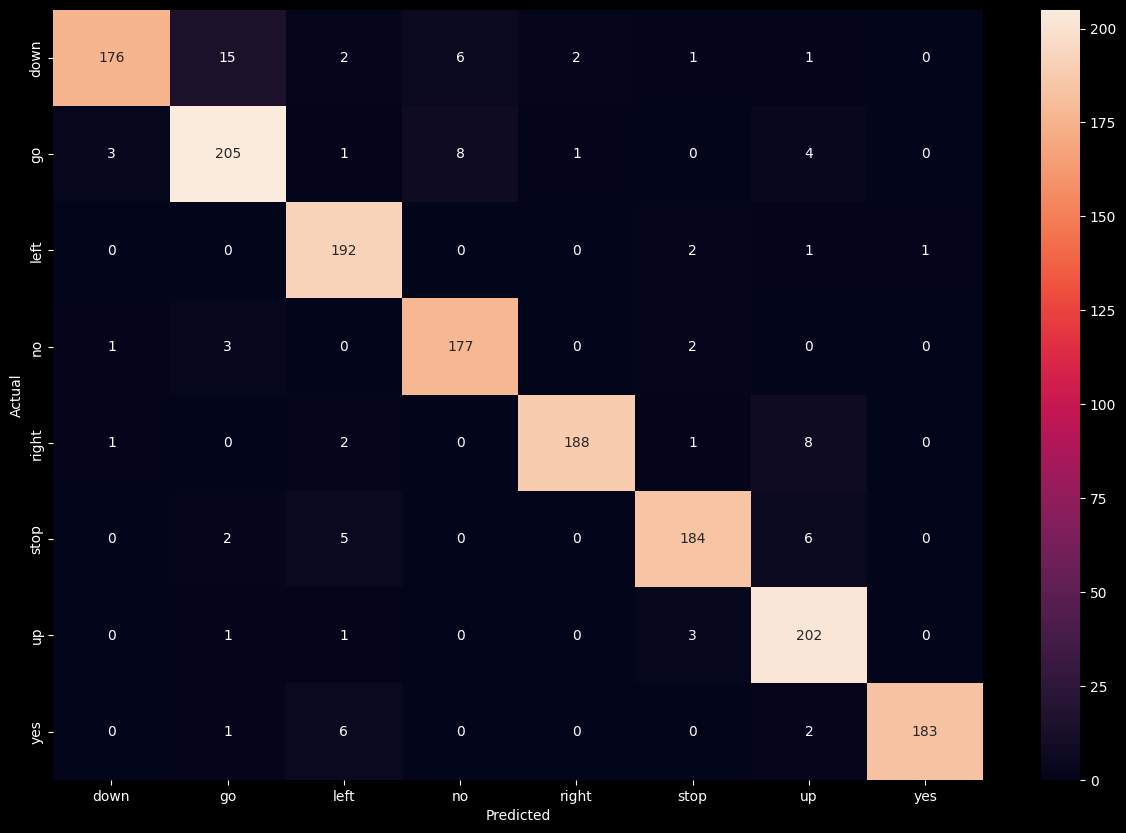

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes_all_labels = [mini_speech_commands.classes[i] for i in all_labels]
classes_all_preds = [mini_speech_commands.classes[i] for i in all_preds]

cm = confusion_matrix(classes_all_labels, classes_all_preds)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=mini_speech_commands.classes, yticklabels=mini_speech_commands.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## Visualizing the embeddings in 2D

With our model trained, we can use the embeddings to visualize the data in 2D. We can use the t-SNE algorithm to reduce the dimensionality of the embeddings to 2D. We can then plot the embeddings in 2D to see if the model has learned to separate the classes.

In [16]:
class VisModel(BaseModel):
    def __init__(self, custom_classifier):
        super(VisModel, self).__init__()
        
        self.custom_classifier = custom_classifier
        self.custom_classifier.to('cpu')
        self.to('cpu')
        
        # freeze the custom classifier
        for param in self.custom_classifier.parameters():
            param.requires_grad = False
        
        self.conv_layers = custom_classifier.conv_layers
        self.pool = custom_classifier.pool
        self.dropout = custom_classifier.dropout
        self.fc1 = custom_classifier.fc1
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pool(x)
        x = x.squeeze(-1)
        x = x.squeeze(-1)
        head1 = x
        head2 = self.fc1(head1)
        return head1, head2

In [20]:
vis_model = VisModel(model)

embeddings_head1, embeddings_head2 = vis_model(X_test_tensor[:400])
embeddings_y = y_test_tensor[:400]

X_encoded_features_head1 = embeddings_head1.detach().numpy()
X_encoded_features_head2 = embeddings_head2.detach().numpy()
y_encoded_labels = embeddings_y.detach().numpy()

In [21]:
X_encoded_features_head1.shape, X_encoded_features_head2.shape, y_encoded_labels.shape

((400, 64), (400, 64), (400,))

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_encoded_features_head1_2d = tsne.fit_transform(X_encoded_features_head1)
X_encoded_features_head2_2d = tsne.fit_transform(X_encoded_features_head2)

In [31]:
y_classes = np.array([mini_speech_commands.classes[i] for i in y_encoded_labels])

centroids_head1 = []
for label in mini_speech_commands.classes:
    mask = y_classes == label
    centroid = X_encoded_features_head1_2d[mask].mean(axis=0)
    centroids_head1.append(centroid)
    
centroids_head2 = []
for label in mini_speech_commands.classes:
    mask = y_classes == label
    centroid = X_encoded_features_head2_2d[mask].mean(axis=0)
    centroids_head2.append(centroid)

In [32]:
import matplotlib.pyplot as plt

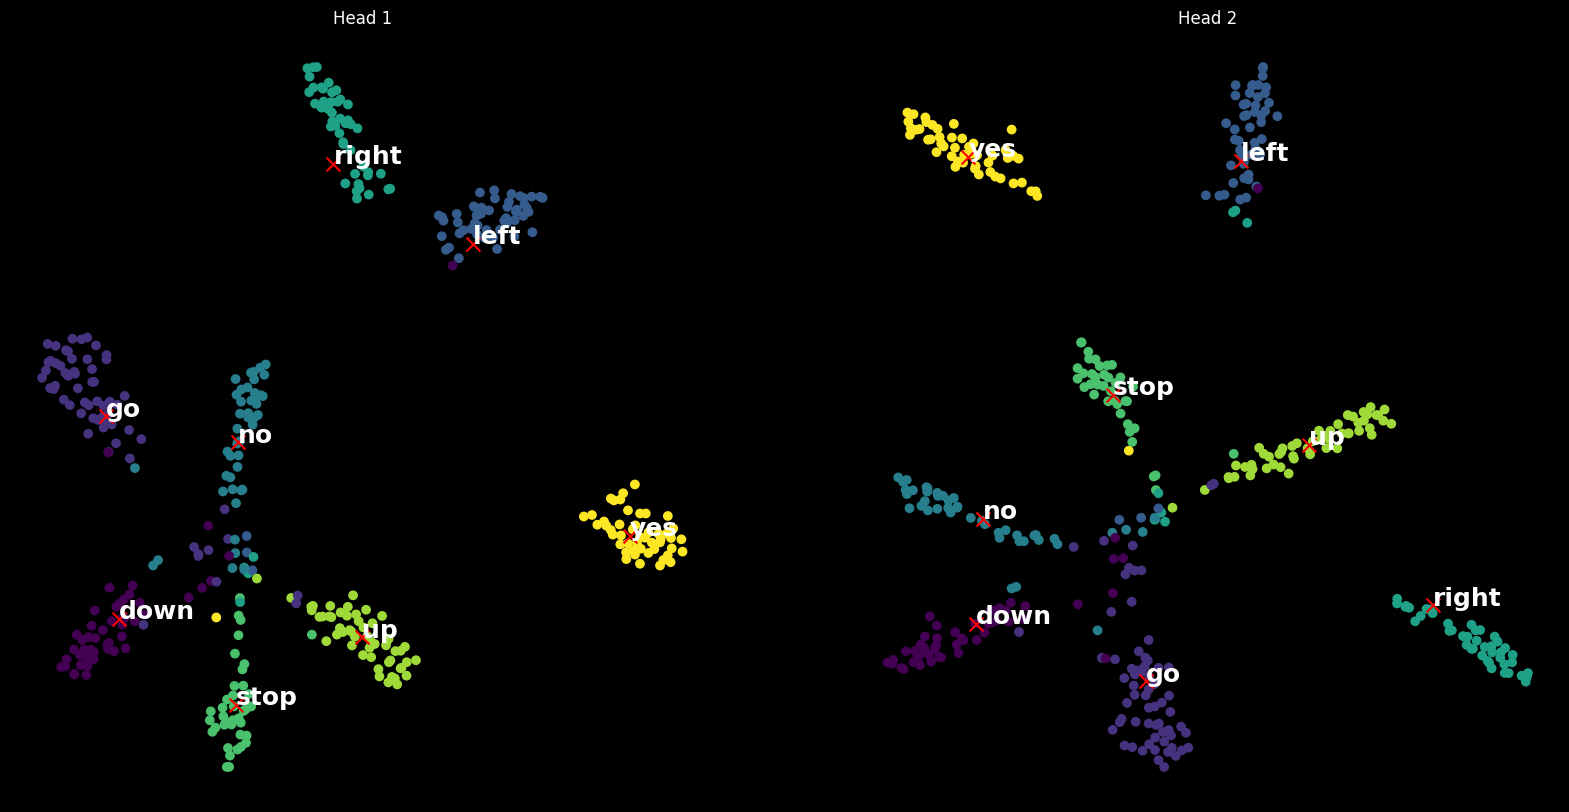

In [36]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].scatter(X_encoded_features_head1_2d[:, 0], X_encoded_features_head1_2d[:, 1], c=y_encoded_labels)
for idx, centroid in enumerate(centroids_head1):
    ax[0].text(centroid[0], centroid[1], mini_speech_commands.classes[idx], fontsize=18, fontweight='bold')
    # Mark with X
    ax[0].scatter(centroid[0], centroid[1], s=100, c='red', marker='x')
ax[0].axis('off')
ax[0].set_title('Head 1')

ax[1].scatter(X_encoded_features_head2_2d[:, 0], X_encoded_features_head2_2d[:, 1], c=y_encoded_labels)
for idx, centroid in enumerate(centroids_head2):
    ax[1].text(centroid[0], centroid[1], mini_speech_commands.classes[idx], fontsize=18, fontweight='bold')
    # Mark with X
    ax[1].scatter(centroid[0], centroid[1], s=100, c='red', marker='x')
ax[1].axis('off')
ax[1].set_title('Head 2')

plt.show()
